# AyuHealth Healthy Food Recommendation
> Healthy Food Recommendation System using Content Based (KNN) & Collaborative Filtering (matrix-factorization) Method

- toc: true
- badges: true
- comments: true
- categories: [Tensorflow, Health&Fitness, Food, KNN]
- image:

## Setup

In [ ]:
!wget https://github.com/sparsh-ai/reco-data/raw/master/ayuhealth/ayuhealth.zip
!unzip ayuhealth.zip

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from datetime import datetime
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from tensorflow.keras.models import load_model

In [50]:
!pip install -q watermark
%reload_ext watermark
%watermark -m -iv

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.19.5
matplotlib: 3.2.2
IPython   : 5.5.0
pandas    : 1.1.5
tensorflow: 2.5.0
sklearn   : 0.0



In [16]:
RATED_FOOD_PATH = 'food.csv'
RATED_FOOD_PATH = 'rated_food.csv'
RATING_PATH = 'ratings.csv'
USER_PATH = 'users.csv'

## KNN model

In [17]:
df = pd.read_csv(RATED_FOOD_PATH)
df.head()

,food_id,food_code,name,category,type,calories,protein,carbs,fat,fiber,sugar,vitamin_a,vitamin_b6,vitamin_b12,vitamin_c,vitamin_d,vitamin_e
0,8,11432000,"Yogurt, low fat milk, fruit",Yogurt,Food,89.0,4.66,14.46,1.37,0.1,12.01,12.0,0.046,0.49,1.8,1.2,0.04
1,13,11435100,"Yogurt, Greek, with oats",Yogurt,Food,160.0,8.90,22.38,4.29,1.9,12.07,88.0,0.077,0.53,0.1,0.7,0.24
2,15,11446000,"Yogurt parfait, low fat, with fruit",Yogurt,Food,84.0,3.36,15.86,1.01,1.1,11.68,30.0,0.233,0.88,14.3,1.2,0.25
3,16,14710200,"Beer cheese soup, made with milk",Soups,Food,192.0,6.19,6.52,15.43,0.3,0.80,182.0,0.037,0.26,0.3,0.3,0.45
4,23,26109133,"Cod, coated, baked or broiled, no added fat",Fish,Food,137.0,17.32,13.10,1.16,0.6,1.15,9.0,0.121,1.81,0.0,0.6,0.54


### Feature selection

In [18]:
knn_df = df.copy()
knn_df.drop(['food_id','food_code','name','category','type'], axis =1, inplace = True)
knn_df.head()

,calories,protein,carbs,fat,fiber,sugar,vitamin_a,vitamin_b6,vitamin_b12,vitamin_c,vitamin_d,vitamin_e
0,89.0,4.66,14.46,1.37,0.1,12.01,12.0,0.046,0.49,1.8,1.2,0.04
1,160.0,8.90,22.38,4.29,1.9,12.07,88.0,0.077,0.53,0.1,0.7,0.24
2,84.0,3.36,15.86,1.01,1.1,11.68,30.0,0.233,0.88,14.3,1.2,0.25
3,192.0,6.19,6.52,15.43,0.3,0.80,182.0,0.037,0.26,0.3,0.3,0.45
4,137.0,17.32,13.10,1.16,0.6,1.15,9.0,0.121,1.81,0.0,0.6,0.54


### Scaling

In [19]:
min_max_scaler = MinMaxScaler()
knn_df = min_max_scaler.fit_transform(knn_df)

### Model fitting

In [20]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(knn_df)
distances, indices = nbrs.kneighbors(knn_df)
all_code = list(df['food_code'].values)

### Testing

In [22]:
# select a random food
random_food_code = np.random.choice(df.food_code.values,1)
random_food_name = df.loc[df.food_code==random_food_code[0],'name'].tolist()[0]

# find 10 similar items
searched_food_code = all_code.index(random_food_code[0])
similar_foods = df.loc[indices[searched_food_code]]

# print results
print("FnB that related to : ", random_food_name)
similar_foods

FnB that related to :  Wrap sandwich, filled with vegetables


,food_id,food_code,name,category,type,calories,protein,carbs,fat,fiber,sugar,vitamin_a,vitamin_b6,vitamin_b12,vitamin_c,vitamin_d,vitamin_e
70,237,58200250,"Wrap sandwich, filled with vegetables",Sandwiches,Food,123.0,3.20,13.96,6.35,1.7,3.05,132.0,0.098,0.03,16.6,0.0,0.33
79,271,72202020,Broccoli casserole with rice,Vegetable dishes,Food,106.0,4.13,15.09,3.50,1.9,1.22,49.0,0.101,0.05,19.8,0.2,0.79
73,263,71704000,Stewed potatoes with tomatoes,Potatoes,Food,94.0,1.61,15.40,3.17,1.4,2.31,13.0,0.221,0.00,12.7,0.0,0.56
86,286,75418020,"Squash, summer, casserole with tomato and cheese",Vegetable dishes,Food,84.0,3.46,8.91,4.19,1.4,3.35,44.0,0.125,0.08,13.8,0.2,0.44
72,251,71601040,"Potato salad with egg, made with Italian dressing",Potatoes,Food,113.0,2.81,15.80,4.42,1.3,2.41,19.0,0.212,0.14,5.3,0.3,0.46
90,293,75440610,Vegetable curry with rice,Vegetable dishes,Food,102.0,2.02,16.43,3.25,1.3,1.96,39.0,0.118,0.01,7.0,0.0,0.67
24,117,27415140,Hunan beef,Stir-fry and soy-based sauce mixtures,Food,105.0,7.08,7.29,5.30,1.5,2.41,63.0,0.161,0.48,11.6,0.1,0.82
16,95,27213010,Biryani with meat,Rice mixed dishes,Food,145.0,8.50,12.20,6.77,1.0,1.69,16.0,0.136,0.47,5.6,0.1,0.25
87,287,75418030,"Squash, summer, casserole, with rice and tomat...",Vegetable dishes,Food,83.0,2.32,14.90,1.65,1.1,2.39,17.0,0.118,0.02,10.4,0.0,0.30
65,214,58160000,Biryani with vegetables,Rice mixed dishes,Food,108.0,1.93,17.88,3.16,1.2,1.16,61.0,0.071,0.01,4.1,0.0,0.20


### Save and load the model

In [23]:
import pickle
 
pickle.dump(nbrs, open('content_based_knn_model.pkl', 'wb'))
 
model = pickle.load(open('content_based_knn_model.pkl', 'rb'))
distances, indices = model.kneighbors(knn_df)

## Collaborative-filtering model

**1. Read Exported CSV From DB**

In [24]:
food_df = pd.read_csv(RATED_FOOD_PATH)
food_df.head()

,food_id,food_code,name,category,type,calories,protein,carbs,fat,fiber,sugar,vitamin_a,vitamin_b6,vitamin_b12,vitamin_c,vitamin_d,vitamin_e
0,8,11432000,"Yogurt, low fat milk, fruit",Yogurt,Food,89.0,4.66,14.46,1.37,0.1,12.01,12.0,0.046,0.49,1.8,1.2,0.04
1,13,11435100,"Yogurt, Greek, with oats",Yogurt,Food,160.0,8.90,22.38,4.29,1.9,12.07,88.0,0.077,0.53,0.1,0.7,0.24
2,15,11446000,"Yogurt parfait, low fat, with fruit",Yogurt,Food,84.0,3.36,15.86,1.01,1.1,11.68,30.0,0.233,0.88,14.3,1.2,0.25
3,16,14710200,"Beer cheese soup, made with milk",Soups,Food,192.0,6.19,6.52,15.43,0.3,0.80,182.0,0.037,0.26,0.3,0.3,0.45
4,23,26109133,"Cod, coated, baked or broiled, no added fat",Fish,Food,137.0,17.32,13.10,1.16,0.6,1.15,9.0,0.121,1.81,0.0,0.6,0.54


In [25]:
rating = pd.read_csv(RATING_PATH)
rating.head()

,rating_id,user_id,food_id,food_code,rating
0,3,1,120,27445220,2
1,4,1,176,32105210,2
2,5,1,184,41311030,3
3,6,1,193,42401100,2
4,7,4,365,42403010,4


In [26]:
user_df = pd.read_csv(USER_PATH)
user_df.head()

,user_id,name,username,email
0,1,Gugun Andriawan,username0,username0@ayohealthy.id
1,4,Mikey,username4,username4@ayohealthy.id
2,5,BrutusSmith,username5,username5@ayohealthy.id
3,6,Guts,username6,username6@ayohealthy.id
4,9,Imam Septian,username9,username9@ayohealthy.id


In [27]:
rating.dropna(inplace=True)

In [28]:
rating.isna().sum()

rating_id    0
user_id      0
food_id      0
food_code    0
rating       0
dtype: int64

### Encode user_id and food_code

In [29]:
user_enc = preprocessing.LabelEncoder()
rating['User_ID'] = user_enc.fit_transform(rating['user_id'])

food_enc = preprocessing.LabelEncoder()
rating['Food_ID'] = food_enc.fit_transform(rating['food_code'])
rating.head()

,rating_id,user_id,food_id,food_code,rating,User_ID,Food_ID
0,3,1,120,27445220,2,0,40
1,4,1,176,32105210,2,0,59
2,5,1,184,41311030,3,0,65
3,6,1,193,42401100,2,0,69
4,7,4,365,42403010,4,1,70


In [30]:
userid_nunique = rating['User_ID'].nunique()
food_unique = rating['Food_ID'].nunique()

print('User_id total unique:', userid_nunique)
print('Food_id total unique:', food_unique)

User_id total unique: 138
Food_id total unique: 140


### Build Tensorflow Recommendation model

In [31]:
def RecommenderV2(n_users, n_food, n_dim):
    
    # User Embedding
    user = Input(shape=(1,))
    U = Embedding(n_users, n_dim)(user)
    U = Flatten()(U)
    
    # Food Rating Embedding
    food = Input(shape=(1,))
    M = Embedding(n_food, n_dim)(food)
    M = Flatten()(M)
    

    merged_vector = concatenate([U, M])
    dense_1 = Dense(128, activation='relu')(merged_vector)
    dense_2 = Dense(64, activation='relu')(dense_1)
    final = Dense(1)(dense_2)
    
    model = Model(inputs=[user, food], outputs=final)
    
    model.compile(optimizer=Adam(0.001), loss='mean_squared_error')
    
    return model

### Model structure

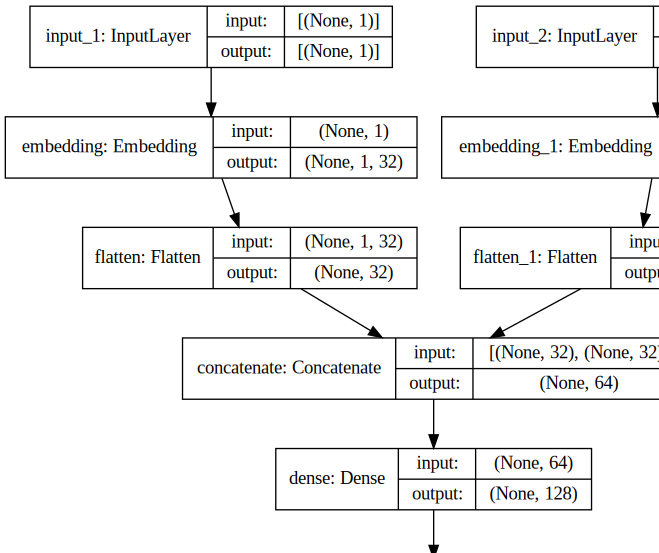

In [32]:
model = RecommenderV2(userid_nunique, food_unique, 32)

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 32)        4416        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 32)        4480        input_2[0][0]                    
______________________________________________________________________________________________

### Train/validation split

In [34]:
X = rating.drop(['rating'], axis=1)
y = rating['rating']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=.2,
                                                  stratify=y,
                                                  random_state=87)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((568, 6), (143, 6), (568,), (143,))

### Setting the callback

In [35]:
checkpoint = ModelCheckpoint('model1.h5', monitor='val_loss', verbose=0, save_best_only=True)
val_loss_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

### Model training

In [36]:
history = model.fit(x=[X_train['User_ID'], X_train['Food_ID']],
                    y=y_train,
                    batch_size=64,
                    epochs=100,
                    verbose=1,
                    validation_data=([X_val['User_ID'], X_val['Food_ID']], y_val),
                    callbacks=[val_loss_cb,checkpoint])

Epoch 1/100
9/9 [==============================] - 1s 25ms/step - loss: 11.7716 - val_loss: 11.2475
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 10.5831 - val_loss: 9.7883
Epoch 3/100
9/9 [==============================] - 0s 6ms/step - loss: 8.6676 - val_loss: 7.2983
Epoch 4/100
9/9 [==============================] - 0s 4ms/step - loss: 5.5824 - val_loss: 3.7903
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 2.5139 - val_loss: 1.8200
Epoch 6/100
9/9 [==============================] - 0s 4ms/step - loss: 1.9538 - val_loss: 1.8666
Epoch 7/100
9/9 [==============================] - 0s 4ms/step - loss: 1.5421 - val_loss: 1.7236
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - loss: 1.3546 - val_loss: 1.7583
Epoch 9/100
9/9 [==============================] - 0s 4ms/step - loss: 1.2252 - val_loss: 1.7750
Epoch 10/100
9/9 [==============================] - 0s 4ms/step - loss: 1.1640 - val_loss: 1.8739


### Plot results

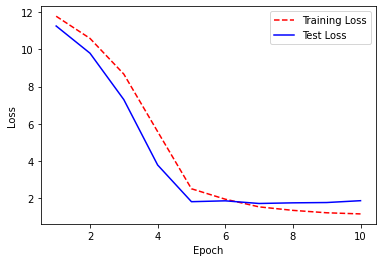

In [37]:
training_loss2 = history.history['loss']
test_loss2 = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss2) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss2, 'r--')
plt.plot(epoch_count, test_loss2, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Recommendation function

In [38]:
def make_pred(user_id, food_id, model):
    return model.predict([np.array([user_id]), np.array([food_id])])[0][0]

In [39]:
def get_topN_rec(user_id, model):
    user_ratings = rating[rating['user_id'] == user_id]
    converted_id = rating[rating['user_id'] == user_id].head(1).User_ID.tolist()

    #remove food that user already rated
    recommendation = rating[~rating['Food_ID'].isin(user_ratings['Food_ID'])][['Food_ID','food_code']].drop_duplicates()
    #predict user rating for every user non rated food
    recommendation['rating_predict'] = recommendation.apply(lambda x: make_pred(converted_id[0], x['Food_ID'], model), axis=1)
    
    #create DF user non rated food sorted by rating prediction descending
    final_rec = recommendation.sort_values(by='rating_predict', ascending=False).merge(food_df[['food_code', 'name','type','category']],on='food_code')
    return final_rec.sort_values('rating_predict', ascending=False)[['name','food_code', 'rating_predict','type','category']]

### Recommending for a single user

In [40]:
model_name = 'model1.h5'
model = load_model(model_name)

USER_ID = np.random.choice(rating.user_id.values,1)[0]
print('USER ID: {} RATED FOOD'.format(USER_ID))
# food_df.loc[food_df['Food_ID'].isin(rating.loc[rating['User_ID']==2]['Food_ID'].to_list())]
rating.loc[rating['user_id']==USER_ID].merge(food_df[['food_code', 'name','category','type']],on='food_code').sort_values(by='rating',ascending=False)

USER ID: 97 RATED FOOD


,rating_id,user_id,food_id,food_code,rating,User_ID,Food_ID,name,category,type
8,482,97,473,95312400,5,82,138,"Energy drink, low calorie (Monster)",Diet drinks,Beverage
1,457,97,324,11321200,4,82,3,"Soy milk, nonfat, chocolate",Milk substitutes,Beverage
5,462,97,146,27550420,4,82,48,"Fish sandwich, grilled",Sandwiches,Food
7,464,97,450,92613510,4,82,134,Cornmeal beverage with chocolate milk,Grain drinks,Beverage
4,461,97,185,41311040,3,82,66,Lentil curry with rice,Bean,Food
6,463,97,341,11513370,3,82,14,"Chocolate milk, made from reduced sugar mix wi...",Milk,Beverage
0,456,97,120,27445220,2,82,40,Kung pao chicken,Stir-fry and soy-based sauce mixtures,Food
3,459,97,147,27550720,2,82,49,"Tuna salad sandwich, on bread",Sandwiches,Food
2,458,97,328,11350030,1,82,7,"Almond milk, unsweetened, chocolate",Milk substitutes,Beverage


In [41]:
print('RECOMENDATION FOR USER ID : ',USER_ID)
rec_result = get_topN_rec(USER_ID, model)
rec_result

RECOMENDATION FOR USER ID :  97


,name,food_code,rating_predict,type,category
0,"Chocolate milk, ready to drink, low fat",11511400,3.727757,Beverage,Milk
1,Fish chowder,28350050,3.644647,Food,Soups
2,"Sushi roll, vegetable",58151230,3.566590,Food,"Egg rolls, dumplings, sushi"
3,"Yogurt, low fat milk, fruit",11432000,3.537811,Food,Yogurt
4,Potato chowder,71803010,3.523988,Food,Soups
...,...,...,...,...,...
126,Broccoli casserole with noodles,72202010,2.368195,Food,Vegetable dishes
127,Oatmeal beverage with milk,92611100,2.292341,Beverage,Grain drinks
128,"Codfish salad, Puerto Rican style, Serenata",27451070,2.167300,Food,Seafood mixed dishes
129,"Watermelon juice, 100%",64133100,2.104285,Beverage,Fruit drinks


### Recommending for all users

In [42]:
# create zeros DF that index representing user_id and columns represending food_code
zeros_df = pd.DataFrame(0,index=sorted(rating['user_id'].unique()),columns=food_df['food_code'].tolist())
zeros_df

,11432000,11435100,11446000,14710200,26109133,26109143,26127123,26137123,26153122,26205160,26303160,26315190,26319121,27150010,27150410,27151070,27213010,27243100,27250020,27250030,27250160,27350070,27350410,27363100,27415140,27416400,27445220,27450010,27450020,27450030,27450070,27450080,27450100,27451070,27550420,27550720,27550800,28310110,28311010,28340110,...,11350030,11370000,11511300,11511400,11513370,11513854,11519205,42403010,42404010,61210010,61210250,64100220,64101010,64104010,64104030,64104600,64124020,64132500,64133100,64134100,64201010,73105000,73105010,75132000,75200700,78101118,92510955,92550040,92550360,92550370,92550400,92582100,92611100,92613010,92613510,94220215,95106000,95110020,95312400,95312410
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
149,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
#create dictionary for every data to labelencoder data
user_dict = {}
food_dict = {}
for index, row in rating.iterrows():
  if(row['user_id'] not in user_dict):
    user_dict[row['user_id']] = row['User_ID']

  if(row['food_code'] not in food_dict):
    food_dict[row['food_code']] = row['Food_ID']

In [ ]:
total_user = len(zeros_df)
for index, row in tqdm(zeros_df.iterrows(), total=zeros_df.shape[0]):
  arr_rated = rating.loc[rating['user_id']==index,'food_code'].tolist()
  for rate in arr_rated:
    zeros_df.loc[index,rate]=rating.loc[(rating['user_id']==index)&(rating['food_code']==rate),'rating'].tolist()[0]

  not_rated = food_df.loc[(~food_df['food_code'].isin(arr_rated)),'food_code'].tolist()
  for rate in not_rated:
    try:

      zeros_df.loc[index,rate]=model.predict([np.array([user_dict[index]]), np.array([food_dict[rate]])])[0][0]
    except:
      zeros_df.loc[index,rate]=0

In [45]:
zeros_df

,11432000,11435100,11446000,14710200,26109133,26109143,26127123,26137123,26153122,26205160,26303160,26315190,26319121,27150010,27150410,27151070,27213010,27243100,27250020,27250030,27250160,27350070,27350410,27363100,27415140,27416400,27445220,27450010,27450020,27450030,27450070,27450080,27450100,27451070,27550420,27550720,27550800,28310110,28311010,28340110,...,11350030,11370000,11511300,11511400,11513370,11513854,11519205,42403010,42404010,61210010,61210250,64100220,64101010,64104010,64104030,64104600,64124020,64132500,64133100,64134100,64201010,73105000,73105010,75132000,75200700,78101118,92510955,92550040,92550360,92550370,92550400,92582100,92611100,92613010,92613510,94220215,95106000,95110020,95312400,95312410
1,3.139826,2.436327,2.914948,3.064059,2.152639,2.811666,2.493906,2.657808,2.584773,2.782626,2.405523,2.669830,2.762791,2.778307,2.040655,2.791096,3.006931,2.926064,1.975425,2.512596,2.617927,2.061943,2.459830,2.476472,3.108277,2.903665,2.000000,2.739681,2.969803,2.857219,1.648037,2.558052,2.536957,1.774757,3.147366,3.262475,2.605367,2.153472,2.872629,2.171800,...,3.023288,2.602319,2.944232,3.327782,2.591735,2.579333,2.841440,2.795774,2.060533,2.880787,2.347380,2.798946,2.859928,2.888787,2.664633,2.941674,2.907800,2.677280,1.710930,2.737759,2.374770,2.252653,2.617842,3.107922,2.452900,2.726054,2.685702,2.907546,2.200970,2.526075,2.846571,2.834219,1.905840,2.395620,2.700983,3.067306,2.507639,2.626426,2.771402,2.835930
4,3.669862,2.965430,3.452461,3.601798,2.669595,3.353076,3.050075,3.191225,3.114342,3.322101,2.941957,3.201020,3.302985,3.300699,2.588086,3.336053,3.541552,3.459570,2.512301,3.053189,3.147243,2.600858,3.009467,3.017641,3.635453,3.428099,3.451886,3.285903,3.501585,3.395110,2.197453,3.105477,3.079295,2.312761,3.664447,3.798048,3.156804,2.704181,3.401925,5.000000,...,3.556667,3.144114,3.490580,3.856461,3.137579,3.114257,3.372025,4.000000,2.595849,3.419743,2.895194,3.335731,3.407485,3.435883,3.205101,3.492666,3.452172,3.217064,2.260697,3.263680,2.909354,2.777401,4.000000,3.641354,2.993044,3.265775,3.226499,3.436700,2.737818,3.062349,3.379939,3.367663,2.436710,2.936510,3.247708,3.597850,3.043602,3.159549,3.310502,3.364701
5,3.418125,2.700677,3.190980,3.347853,2.417435,3.093761,2.783133,2.940970,2.862434,3.064229,2.689584,2.953817,3.049258,3.046716,2.314783,3.067389,3.283703,3.204821,2.260939,2.795557,3.000000,2.337665,2.741246,2.762860,3.388149,3.178975,4.000000,3.024255,3.251913,3.132350,1.000000,2.845098,2.818588,2.049076,3.431306,3.539194,2.894186,2.436807,3.155767,2.458141,...,2.000000,2.886539,3.234364,5.000000,2.872076,2.864752,3.116311,3.075591,2.338839,3.163671,2.629338,3.080821,3.140918,3.176437,2.948175,3.230287,3.195191,2.959949,1.968241,3.021387,2.655794,2.520521,2.883660,3.395758,2.732279,3.010690,2.972227,3.179803,2.469668,2.804341,3.120473,3.114037,2.174402,2.679722,2.981174,3.344523,2.788077,2.908690,3.049494,3.108704
6,3.140695,2.430627,2.920830,3.074741,2.142952,2.815847,2.518559,2.661634,2.592177,2.789658,2.416993,2.687958,2.768197,2.775356,2.047959,2.797256,3.011007,5.000000,1.994749,3.000000,2.619419,2.077413,2.469057,2.494969,3.114035,2.903510,2.914690,2.746105,3.000000,2.859377,1.660676,2.576134,2.553147,1.774537,3.141793,3.267422,2.626473,2.173021,2.879908,2.186207,...,3.023678,2.619180,2.960673,3.325539,2.598362,2.585235,2.842360,2.806824,2.077277,2.885804,2.364807,2.808401,1.000000,2.903756,2.672080,2.955141,2.920173,2.690963,1.702841,2.748159,2.379744,2.251827,2.617647,3.115585,2.460579,4.000000,2.702945,2.911737,2.203524,2.532005,2.845287,2.833868,1.893058,2.408458,2.707647,3.066044,2.504212,2.636261,2.776914,2.830992
9,4.110233,3.388631,3.884682,4.036623,3.111693,3.777340,3.467085,3.629374,3.551180,3.754636,3.377228,3.636917,3.735910,3.732535,3.010739,3.767941,3.967769,3.900068,2.944485,3.487451,3.578137,3.019035,3.429563,3.444891,4.071072,3.871523,3.876201,3.708824,3.939196,3.826731,2.604108,3.524544,3.512851,2.735122,4.113176,5.000000,3.585566,3.122374,3.000000,3.139116,...,3.986

In [46]:
food_name_dict = {}
for index, row in food_df.iterrows():
    if(row['food_code'] not in food_name_dict):
        food_name_dict[row['food_code']] = row['name']

**Give Recommendation to One User**

In [47]:
USER_ID = 129
food_code_arr = []
name_arr = []
prediction_arr = []
user_rated_food_code = rating.loc[rating['user_id']==USER_ID,'food_code'].tolist()
for key, value in zeros_df.loc[int(USER_ID)].items():
  if(int(key) not in user_rated_food_code):
    food_code_arr.append(int(key))
    name_arr.append(food_name_dict[int(key)])
    prediction_arr.append(value)

In [48]:
print('Recommendation for user id : {}'.format(USER_ID))
rating.loc[rating['user_id']==USER_ID].merge(food_df[['food_code', 'name','category','type']],on='food_code').sort_values(by='rating',ascending=False)

Recommendation for user id : 129


,rating_id,user_id,food_id,food_code,rating,User_ID,Food_ID,name,category,type
0,615,129,202,58151200,5,114,76,"Sushi roll, salmon","Egg rolls, dumplings, sushi",Food
1,616,129,204,58151220,5,114,78,Sushi roll tuna,"Egg rolls, dumplings, sushi",Food
6,621,129,370,61210010,5,114,88,"Orange juice, 100%, freshly squeezed",Fruit drinks,Beverage
2,617,129,203,58151210,4,114,77,"Sushi roll, shrimp","Egg rolls, dumplings, sushi",Food
5,620,129,372,61210250,4,114,89,"Orange juice, 100%, with calcium added, canned...",Fruit drinks,Beverage
3,618,129,170,32103030,2,114,57,"Egg salad, made with creamy dressing",Eggs and omelets,Food
4,619,129,183,41311020,2,114,64,"Sambar, vegetable stew",Vegetable dishes,Food


In [51]:
recommendation_columns = {'food_code': food_code_arr,
                          'name': name_arr,
                          'predicted_rating': prediction_arr,
                          }

rec_for_user = pd.DataFrame(data=recommendation_columns)

# SORTED RATING FOR ONE USER
rec_for_user.sort_values(by='predicted_rating', ascending=False)

,food_code,name,predicted_rating
98,11511400,"Chocolate milk, ready to drink, low fat",4.190182
35,27550720,"Tuna salad sandwich, on bread",4.137423
41,28350050,Fish chowder,4.124354
58,58151230,"Sushi roll, vegetable",4.039911
0,11432000,"Yogurt, low fat milk, fruit",4.014369
...,...,...,...
73,72202010,Broccoli casserole with noodles,2.846332
125,92611100,Oatmeal beverage with milk,2.766398
33,27451070,"Codfish salad, Puerto Rican style, Serenata",2.646078
111,64133100,"Watermelon juice, 100%",2.578853


### Save predicted data to csv file

In [52]:
zeros_df.to_csv('recs.csv', index=True)